In [2]:
import serial
from ReadWrite import ReadWrite
import pandas as pd
from matplotlib import pyplot as plt
from Network import RKMNetwork
from func_timeout import func_timeout, FunctionTimedOut
import time
import ast
import numpy as np
from scipy.interpolate import make_smoothing_spline
import os
lam = 20
import random

/Users/laltman2/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [237]:
port = "/dev/cu.usbmodem101"  # Replace with your serial port
baudrate = 250000
ser = serial.Serial(port, baudrate)
ser.is_open

True

Graph with 6 nodes and 8 edges
  name  isWeight Anode Bnode
0  BV0         0    A0    V0
1  BV1         0    A0    V1
2  BH0         0    A0    H0
3  BH1         0    A0    H1
4  W00         1    V0    H0
5  W01         1    V0    H1
6  W10         1    V1    H0
7  W11         1    V1    H1
  name
0   A0
1   H0
2   H1
3   V0
4   V1


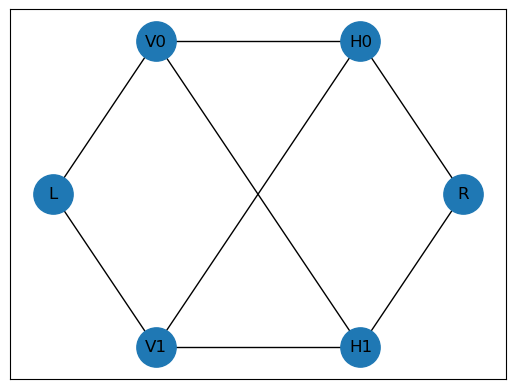

In [6]:
numV = 2
numH = 2

net = RKMNetwork(numV,numH)

net.draw_network()

print(net.edge)
print(net.node)

In [236]:
def cleanup_dict(thisdict): 
    aConvert = (3.3)/(4095.)
    ki = thisdict['ki']
    DA = thisdict['DA']
    DB = thisdict['DB']
    RA = thisdict['RA']
    RB = thisdict['RB']
    
    analogV = thisdict['analogV']
    analogH = thisdict['analogH']
    
    nmestimes = 5. #thisdict['nmestimes']
    aConvert = aConvert*1/nmestimes
    
    if not (net.run_nodechecks(DA, DB) and net.run_nodechecks(RA, RB)):
        print("failed nodecheck")
        return None
    
    edges = dict(zip(edgekeys, ki))
    
    Dnodes = dict(zip(Anodekeys, DA))
    Dnodes.update(dict(zip(Bnodekeys, DB)))
    
    Rnodes = dict(zip(Anodekeys, RA))
    Rnodes.update(dict(zip(Bnodekeys, RB)))
    
    azero = np.array(thisdict['analogZero'], dtype='float')*aConvert
    
    newdict = {'epoch': thisdict['epoch'], 'trainingstep': thisdict['trainingstep'], 
               'Vtest': thisdict['Vtest'], 'Vrecon': thisdict['Vrecon'], 'analogZero': azero}
    newdict.update(edges)
    
    for key in Dnodes:
        newdict['D' + key] = Dnodes[key]
    
    for key in Rnodes:
        newdict['R' + key] = Rnodes[key]
        
    for i, val in enumerate(analogV):
        newdict['aV' + str(i)] = val*aConvert
        
    for i, val in enumerate(analogH):
        newdict['aH' + str(i)] = val*aConvert
        
    return newdict

In [229]:
ser.close()

In [238]:
RW = ReadWrite(ser)

In [242]:
# RW.send_recieve("resetval;0;")
# RW.send_recieve("reset;")

rand1 = 0
rand2 = 0
while(rand1==rand2):
    rand1 = random.uniform(0,100)
    ran2 = random.uniform(0,100)

RW.send_recieve("seed;1;{};".format(rand1))
RW.send_recieve("seed;2;{};".format(rand2))

time.sleep(1)

RW.send_message("mes;")
mes = RW.measure()
eki = mes['ki']
DA = mes['DA']
DB = mes['DB']
RA = mes['RA']
RB = mes['RB']

print(net.run_nodechecks(DA, DB))
print(net.run_nodechecks(RA, RB))

print(dict(zip(edgekeys, eki)))

d1 = dict(zip(Anodekeys, DA))
d1.update(dict(zip(Bnodekeys, DB)))

r1 = dict(zip(Anodekeys, RA))
r1.update(dict(zip(Bnodekeys, RB)))

print(d1, r1)

board, 1
seed, 59
finished
board, 2
seed, 0
finished
ki, [-2, 0, -1, 1, 4, 5, 8, 2]
DA, [1, 1, 1, 1, 1, 1, 1, 1]
DB, [1, 1, 1, 1, 1, 1, 1, 1]
RA, [1, 1, 1, 1, 1, 1, 1, 1]
RB, [1, 1, 1, 1, 1, 1, 1, 1]
finished
True
True
{'BV0': -2, 'BV1': 0, 'BH0': -1, 'BH1': 1, 'W00': 4, 'W01': 5, 'W10': 8, 'W11': 2}
{'A0': 1, 'V0': 1, 'V1': 1, 'H0': 1, 'H1': 1} {'A0': 1, 'V0': 1, 'V1': 1, 'H0': 1, 'H1': 1}


In [256]:
# get an ensemble of trainings

ensemblename = 'test2x2_011426_T10mV'
epochs= 200
trials = 5
alpha = 1
kwvar = 20
kbvar = 5

if not os.path.exists('data/trainings/{}/'.format(ensemblename)):
        os.mkdir('data/trainings/{}/'.format(ensemblename))

RW.send_recieve("alpha;{};".format(alpha))
time.sleep(1)
RW.send_recieve("kwvar;{};".format(kwvar))
time.sleep(1)
RW.send_recieve("kbvar;{};".format(kbvar))
time.sleep(1)

for t in range(trials):
    print('Trial {}'.format(t))

    RW.send_recieve("fb;0;")
    time.sleep(1)
    RW.send_recieve("useprev;0;")
    time.sleep(1)
    RW.send_recieve("clamp;0;0;")
    time.sleep(1)
    RW.send_recieve("reset;")
    time.sleep(1)
    RW.send_recieve("norm;")
    RW.clear_output()
    time.sleep(1)
    RW.send_message("mes;")
    eki = RW.measure()['ki']

    first = dict(zip(edgekeys, eki))
    first['epoch'] = -1
    first['trainingstep'] = -1

    RW.send_message("train;{};".format(epochs))
    listodicts = RW.train_measure()

    listodicts[0].update(first)

    for i in range(1, len(listodicts)):
        listodicts[i] = cleanup_dict(listodicts[i])

    df = pd.DataFrame(listodicts)
    df.epoch = pd.to_numeric(df.epoch)
    df.trainingstep = pd.to_numeric(df.trainingstep)
    
    MSEs = []

    for trainingstep in df.trainingstep:
        row = df[df.trainingstep == trainingstep].iloc[0]


        Vtest = np.array(row.Vtest).T
        Vrecon = np.array(row.Vrecon).T
        MSE = np.mean(np.linalg.norm(Vtest-Vrecon, axis=0))
        MSEs.append(MSE)
    

    MSEs = np.array(MSEs)
    df['MSE'] = MSEs
    print('Done with training')
    df.to_csv('data/trainings/{}/train{}.csv'.format(ensemblename, str(t).zfill(2)))

alpha, 1
finished
kwvar, 20
finished
kbvar, 5
finished
Trial 0
FB, 0
finished
useprev, 0
finished
clamped_vals, [0, 0]
finished
reset
finished
normed
finished
ki, [-1, -2, -4, 1, -7, -11, -3, -10]
DA, [1, 1, 1, 1, 0, 0, 1, 1]
DB, [0, 1, 1, 0, 1, 0, 1, 0]
RA, [1, 1, 1, 1, 0, 0, 1, 1]
RB, [0, 1, 1, 0, 1, 0, 1, 0]
finished
Done with training
Trial 1
FB, 0
finished
useprev, 0
finished
clamped_vals, [0, 0]
finished
reset
finished
normed
finished
ki, [-4, 2, 4, -4, -7, -19, -4, 1]
DA, [1, 1, 1, 1, 1, 1, 1, 1]
DB, [1, 1, 0, 0, 0, 0, 0, 0]
RA, [1, 1, 1, 1, 1, 1, 1, 1]
RB, [1, 1, 0, 0, 0, 0, 0, 0]
finished
Done with training
Trial 2
FB, 0
finished
useprev, 0
finished
clamped_vals, [0, 0]
finished
reset
finished
normed
finished
ki, [0, 3, 4, 2, -1, -2, 6, 2]
DA, [1, 1, 1, 1, 0, 0, 1, 1]
DB, [0, 1, 1, 0, 1, 0, 1, 0]
RA, [1, 1, 1, 1, 1, 1, 1, 1]
RB, [1, 1, 1, 1, 1, 1, 1, 1]
finished
Done with training
Trial 3
FB, 0
finished
useprev, 0
finished
clamped_vals, [0, 0]
finished
reset
finished
normed
fi

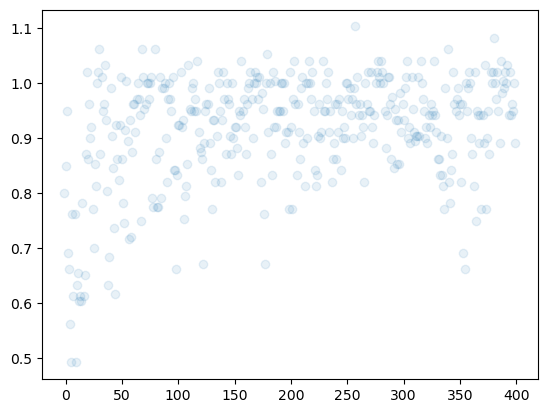

In [257]:
plt.scatter(df.trainingstep, df.MSE, alpha=0.1)
# plt.plot(df.trainingstep, df.MSE)

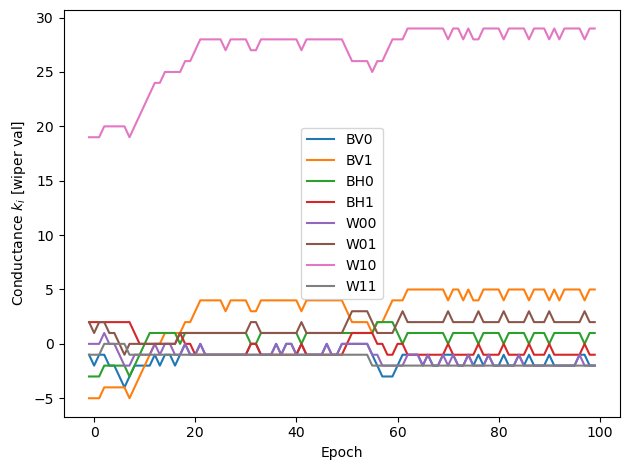

In [253]:
fig, ax = plt.subplots()
for c in df.columns:
    if c[0] == "B" or c[0] == "W":
        ax.plot(df.trainingstep, df[c], label = c)
ax.legend()

ax.set_xlabel("Epoch")
ax.set_ylabel('Conductance $k_i$ [wiper val]')
fig.tight_layout()

In [7]:
maxtrain = np.max(df.trainingstep)
show = [0, maxtrain]
# show = np.arange(0, maxtrain, 40)
# show = np.arange(0, 30, 5)
# show = [maxtrain]
# show = np.arange(10)
for trainingstep in show:
    row = df[df.trainingstep == trainingstep].iloc[0]

    Vtest = np.array(row.Vtest).T
    Vrecon = np.array(row.Vrecon).T
    MSE = np.mean(np.linalg.norm(Vtest-Vrecon, axis=0))
    print(MSE)

    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,4))
    fig.suptitle("Step{}".format(trainingstep))
    ax1.imshow(Vtest, cmap='binary')
    ax1.set_title('Test')
#     plt.show()
    ax2.imshow(Vrecon, cmap='binary')
    ax2.set_title("Reconstruction")
#     fig.savefig('figures/')
    plt.show()
    # Vrecons

NameError: name 'df' is not defined

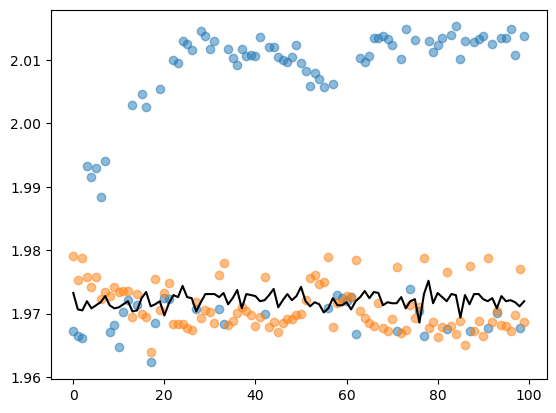

In [254]:
plt.plot(df.trainingstep, df.analogZero, c='k', zorder=5)
plt.scatter(df.trainingstep, df.aH0, alpha=0.5)
plt.scatter(df.trainingstep, df.aH1, alpha=0.5)
plt.show()

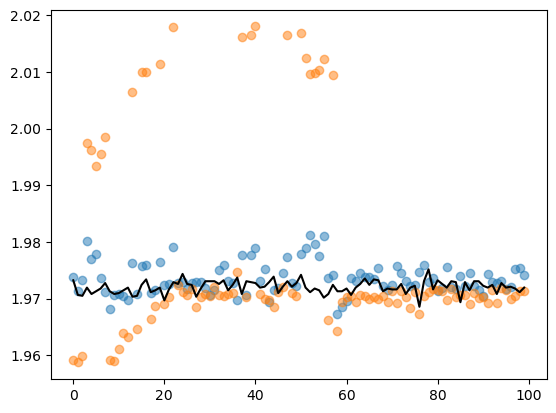

In [255]:
plt.plot(df.trainingstep, df.analogZero, c='k', zorder=5)
plt.scatter(df.trainingstep, df.aV0, alpha=0.5)
plt.scatter(df.trainingstep, df.aV1, alpha=0.5)
plt.show()